# Impact of geo-distribution and mining pools on  Ethereum: dataset and metrics

The "ethereum-network-measurement" dataset contains a snapshot of the Ethereum network (April 1st 2019 - May 2nd 2019) captured by 4 geographically distant Ethereum instances.
* 216,656,blocks (including forks) with the block numbers ranging from 7,479,573 to 7,680,658.
* 21,960,051 unique transactions (out of which 20,654,578 (94%) were valid transactions included in main blocks).

The tools for extracting the full set of metrics can be found here:
https://github.com/vavricka/Ethereum-monitoring-node/tree/master/metrics

* This notebook contains only a small selection of the tools and metrics from the github repository mentioned above.
* Due to the Kaggle's RAM space restrictions the metrics are calculated only on a subset of transactions (~1/4).


# Gas used per transaction type

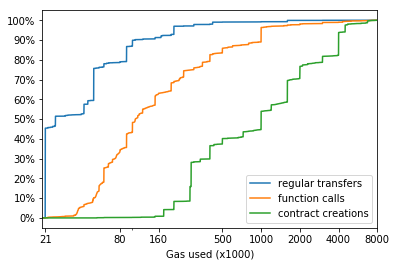

In [1]:
#!/usr/bin/python3
import pandas as pd
import numpy as np
import sys
import os

import matplotlib.pyplot as plt

TXS_LOG = "/kaggle/input/ethereum-network-measurement/transactions.csv/transactions.csv"

dtypes = {
        'LocalTimeStamp'    : 'object',
        'Hash'              : 'object',
        'GasLimit'          : 'object',
        'GasPrice'          : 'object',
        'Value'             : 'object',
        'Nonce'             : 'object',
        'MsgType'           : 'object',
        'Cost'              : 'object',
        'Size'              : 'object',
        'To'                : 'object',
        'From'              : 'object',
        'ValidityErr'       : 'object',
        'CapturedLocally'   : 'object',
        'GasUsed'           : 'float',
        'InMainBlock'       : 'object',
        'InUncleBlocks'     : 'object',
        'InOrder'           : 'object',
        'NeverCommitting'    : 'object',
        'CommitTime0'       : 'float',
        'CommitTime3'       : 'float',
        'CommitTime12'      : 'float',
        'CommitTime36'      : 'float',
        }

# DUE TO KAGGLE'S RAM LIMIT
# we drop 3/4 of all txs and perfrom this metric only on one quarter of them (5,000,000 out of ~ 20,000,000)
# run this metric on a machine with RAM big enough if you want to cover all of them
txs = pd.read_csv(TXS_LOG, skiprows=1, engine = 'python', nrows=5000000, 
    names=['LocalTimeStamp','Hash','GasLimit','GasPrice','Value','Nonce','MsgType',
            'Cost','Size','To','From','ValidityErr','CapturedLocally','GasUsed',
            'InMainBlock','InUncleBlocks','InOrder','NeverCommitting',
            'CommitTime0','CommitTime3','CommitTime12','CommitTime36'],
            usecols=['Hash', 'MsgType', 'ValidityErr', 'GasUsed','NeverCommitting'],
            dtype=dtypes)

# drop txs w/ GasUsed nil, validityErr != nil; committed txs only (these are surely valid)
condition = txs[  (txs['GasUsed'].isnull()) | (txs['ValidityErr'] != "nil") | (txs['NeverCommitting'] != "Committed") ].index
txs.drop(condition , inplace=True)

# print  txs after drop
#print("Txs TOTAL (after drop): ", len(txs.index))

tx_only = txs[txs.MsgType == "TX"]
mc_only = txs[txs.MsgType == "MC"]
cc_only = txs[txs.MsgType == "CC"]

#print ("TX:", len(tx_only), tx_only.GasUsed.min(),tx_only.GasUsed.max(),tx_only.GasUsed.median(),tx_only.GasUsed.mean() )   #min max median mean
#print ("MC:", len(mc_only), mc_only.GasUsed.min(),mc_only.GasUsed.max(),mc_only.GasUsed.median(),mc_only.GasUsed.mean() )
#print ("CC:", len(cc_only), cc_only.GasUsed.min(),cc_only.GasUsed.max(),cc_only.GasUsed.median(),cc_only.GasUsed.mean() )

s_tx = txs[txs.MsgType == "TX"].GasUsed
s_mc = txs[txs.MsgType == "MC"].GasUsed
s_cc = txs[txs.MsgType == "CC"].GasUsed

bin_seq = list(range(0,8000000,20)) 

fig, ax = plt.subplots()

counts_tx, bin_edges_tx = np.histogram (s_tx, bins=bin_seq)
cdf_tx = np.cumsum (counts_tx)
lineTx, = ax.plot (bin_edges_tx[1:], cdf_tx/cdf_tx[-1], label='regular transfers')

counts_mc, bin_edges_mc = np.histogram (s_mc, bins=bin_seq)
cdf_mc = np.cumsum (counts_mc)
lineMc, = ax.plot (bin_edges_mc[1:], cdf_mc/cdf_mc[-1], label='function calls')

counts_cc, bin_edges_cc = np.histogram (s_cc, bins=bin_seq)
cdf_cc = np.cumsum (counts_cc)
lineCc, = ax.plot (bin_edges_cc[1:], cdf_cc/cdf_cc[-1], label='contract creations')

plt.xlabel('Gas used (x1000)')
plt.yticks(np.arange(0, 1.1, step=0.1),['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])

plt.xscale('symlog')
ax.set_xlim(left=20000)
ax.set_xlim(right=8000000)

nums = [21000,80000,160000,500000,1000000,2000000,4000000,8000000]
labels = ['21', '80', '160', '500', '1000', '2000', '4000', '8000']

plt.xticks(nums, labels)

#for q in [50, 70, 75, 90, 95, 100]:
#    print ("reg tx  :{}%% percentile: {}".format (q, np.percentile(s_tx, q)))
#    print ("Msg call:{}%% percentile: {}".format (q, np.percentile(s_mc, q)))
#    print ("con crea:{}%% percentile: {}".format (q, np.percentile(s_cc, q)))

ax.legend()
plt.show()


# Impact of gas price type
In this metric, we analyze the correlation between the commit time and the gas
price of a transaction which is defined by the sender. It is expected that
high gas price will lead to a higher probability of low commit time. This
happens because miners are incentivized to include those transactions to make
more profit. This metric is in order to observe whether it is possible to
speed up the commit time by offering a higher gas price.



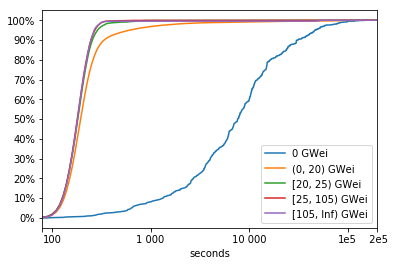

In [2]:
#!/usr/bin/python3
import pandas as pd
import numpy as np
import sys
import os

import inspect
import matplotlib.pyplot as plt

TXS_LOG = "/kaggle/input/ethereum-network-measurement/transactions.csv/transactions.csv"

dtypes = {
        'LocalTimeStamp'    : 'object',
        'Hash'              : 'object',
        'GasLimit'          : 'object',
        'GasPrice'          : 'float',
        'Value'             : 'object',
        'Nonce'             : 'object',
        'MsgType'           : 'object',
        'Cost'              : 'object',
        'Size'              : 'object',
        'To'                : 'object',
        'From'              : 'object',
        'ValidityErr'       : 'object',
        'CapturedLocally'   : 'object',
        'GasUsed'           : 'object',
        'InMainBlock'       : 'object',
        'InUncleBlocks'     : 'object',
        'InOrder'           : 'object',
        'NeverCommitting'    : 'object',
        'CommitTime0'       : 'float',
        'CommitTime3'       : 'float',
        'CommitTime12'      : 'float',
        'CommitTime36'      : 'float',
        }

# DUE TO KAGGLE'S RAM LIMIT
# we drop 3/4 of all txs and perfrom this metric only on one quarter of them (5,000,000 out of ~ 20,000,000)
# run this metric on a machine with RAM big enough if you want to cover all of them
txs = pd.read_csv(TXS_LOG, skiprows=1, engine = 'python', nrows=5000000, 
    names=['LocalTimeStamp','Hash','GasLimit','GasPrice','Value','Nonce','MsgType',
            'Cost','Size','To','From','ValidityErr','CapturedLocally','GasUsed',
            'InMainBlock','InUncleBlocks','InOrder','NeverCommitting',
            'CommitTime0','CommitTime3','CommitTime12','CommitTime36'],
            #usecols=['GasPrice','Hash','CommitTime0','CommitTime3','CommitTime12','CommitTime36'],
            usecols=['GasPrice','CommitTime12','ValidityErr'],
            dtype=dtypes)

# drop all txs without CommitTime12
condition = txs[ txs['CommitTime12'].isnull() ].index
txs.drop(condition , inplace=True)

s_txs0        = txs[txs.GasPrice == 0].CommitTime12
s_txs0to20    = txs[(txs.GasPrice > 0) & (txs.GasPrice < 20000000000)].CommitTime12
s_txs20to25    = txs[(txs.GasPrice >= 20000000000) & (txs.GasPrice < 25000000000)].CommitTime12
s_txs25to105    = txs[(txs.GasPrice >= 25000000000) & (txs.GasPrice < 105000000000)].CommitTime12
s_txs105up    = txs[(txs.GasPrice >= 105000000000) ].CommitTime12

#print("TXS all:",len(txs))
#print("0:",len(s_txs0))
#print("0 to 20:",   len(s_txs0to20))
#print("20 to 25:",  len(s_txs20to25))
#print("25 to 105:", len(s_txs25to105))
#print("105Gwei+:",  len(s_txs105up))

max_delay = 200000
bin_seq = list(range(0,max_delay,10))  
fig, ax = plt.subplots()

counts_txs0, bin_edges_txs0 = np.histogram (s_txs0, bins=bin_seq)
cdf_txs0 = np.cumsum (counts_txs0)
linetxs0, = ax.plot (bin_edges_txs0[1:], cdf_txs0/cdf_txs0[-1], label='0 GWei')

counts_txs0to20, bin_edges_txs0to20 = np.histogram (s_txs0to20, bins=bin_seq)
cdf_txs0to20 = np.cumsum (counts_txs0to20)
linetxs0to20, = ax.plot (bin_edges_txs0to20[1:], cdf_txs0to20/cdf_txs0to20[-1], label='(0, 20) GWei')

counts_txs20to25, bin_edges_txs20to25 = np.histogram (s_txs20to25, bins=bin_seq)
cdf_txs20to25 = np.cumsum (counts_txs20to25)
linetxs20to25, = ax.plot (bin_edges_txs20to25[1:], cdf_txs20to25/cdf_txs20to25[-1], label='[20, 25) GWei')

counts_txs25to105, bin_edges_txs25to105 = np.histogram (s_txs25to105, bins=bin_seq)
cdf_txs25to105 = np.cumsum (counts_txs25to105)
linetxs25to105, = ax.plot (bin_edges_txs25to105[1:], cdf_txs25to105/cdf_txs25to105[-1], label='[25, 105) GWei')

counts_txs105up, bin_edges_txs105up = np.histogram (s_txs105up, bins=bin_seq)
cdf_txs105up = np.cumsum (counts_txs105up)
lines_txs105up, = ax.plot (bin_edges_txs105up[1:], cdf_txs105up/cdf_txs105up[-1], label='[105, Inf) GWei')


plt.xlabel('seconds')
plt.yticks(np.arange(0, 1.1, step=0.1),['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
#
plt.xscale('symlog')
ax.set_xlim(left=80)
ax.set_xlim(right=max_delay)    #TODO increase for 1 month last. logs
#
nums = [80,100,1000,10000,100000,200000]  #TODO increase for 1 month last. logs
labels = ['','100','1 000','10 000','1e5',' 2e5']   #TODO increase for 1 month last. logs

plt.xticks(nums, labels)

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

#for txtype in [s_txs0, s_txs0to20, s_txs20to25, s_txs25to105, s_txs105up]:
#    for q in [50, 90, 95, 98, 99, 99.5, 100]:
#        print (retrieve_name(txtype)[0], ":{}%% percentile: {}".format (q, np.percentile(txtype, q)))

ax.legend()
plt.show()


# Transaction reordering

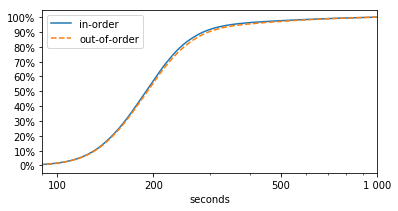

In [3]:
#!/usr/bin/python3
import pandas as pd
import numpy as np
import sys
import os
from pathlib import Path
from matplotlib.pyplot import figure
import inspect

import matplotlib.pyplot as plt

TXS_LOG = "/kaggle/input/ethereum-network-measurement/transactions.csv/transactions.csv"

dtypes = {
        'LocalTimeStamp'    : 'object',
        'Hash'              : 'object',
        'GasLimit'          : 'object',
        'GasPrice'          : 'float',
        'Value'             : 'object',
        'Nonce'             : 'object',
        'MsgType'           : 'object',
        'Cost'              : 'object',
        'Size'              : 'object',
        'To'                : 'object',
        'From'              : 'object',
        'ValidityErr'       : 'object',
        'CapturedLocally'   : 'object',
        'GasUsed'           : 'object',
        'InMainBlock'       : 'object',
        'InUncleBlocks'     : 'object',
        'InOrder'           : 'object',
        'NeverCommitting'    : 'object',
        'CommitTime0'       : 'float',
        'CommitTime3'       : 'float',
        'CommitTime12'      : 'float',
        'CommitTime36'      : 'float',
        'CommitTime15'      : 'float',
        }

# DUE TO KAGGLE'S RAM LIMIT
# we drop 3/4 of all txs and perfrom this metric only on one quarter of them (5,000,000 out of ~ 20,000,000)
# run this metric on a machine with RAM big enough if you want to cover all of them
txs = pd.read_csv(TXS_LOG, skiprows=1, engine = 'python', nrows=5000000, 
    names=['LocalTimeStamp','Hash','GasLimit','GasPrice','Value','Nonce','MsgType',
            'Cost','Size','To','From','ValidityErr','CapturedLocally','GasUsed',
            'InMainBlock','InUncleBlocks','InOrder','NeverCommitting',
            'CommitTime0','CommitTime3','CommitTime12','CommitTime36'],
            #usecols=['GasPrice','Hash','CommitTime0','CommitTime3','CommitTime12','CommitTime36'],
            usecols=['NeverCommitting','From','Nonce','InOrder','CommitTime12'],
            dtype=dtypes)

# drop all txs without InOrder (those not Committed)  and  without commitTime12 set
condition = txs[  (txs['InOrder'].isnull()) | (txs['CommitTime12'].isnull()) ].index
txs.drop(condition , inplace=True)

s_in_order     = txs[txs.InOrder == "True"].CommitTime12
s_out_of_order = txs[txs.InOrder == "False"].CommitTime12

bin_seq = list(range(0,1000,5))   #TODO increase for 1 month last. logs (10000 good for 4-days) .. 1 000 000 ?
fig, ax = plt.subplots()

fig.set_size_inches(6,3, forward=True)

counts_in, bin_edges_in = np.histogram (s_in_order, bins=bin_seq)
cdf_in = np.cumsum (counts_in)
linetxs0, = ax.plot (bin_edges_in[1:], cdf_in/cdf_in[-1], label='in-order', linestyle='-')

counts_out, bin_edges_out = np.histogram (s_out_of_order, bins=bin_seq)
cdf_out = np.cumsum (counts_out)
linetxs0to20, = ax.plot (bin_edges_out[1:], cdf_out/cdf_out[-1], label='out-of-order', linestyle='--')

plt.xlabel('seconds')
plt.yticks(np.arange(0, 1.1, step=0.1),['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
#
plt.xscale('log')
ax.set_xlim(left=90)
ax.set_xlim(right=1000)    #TODO increase for 1 month last. logs
#
nums = [100,200,500,1000]  #TODO increase for 1 month last. logs
labels = ['100','200','500','1 000']   #TODO increase for 1 month last. logs

plt.xticks(nums, labels)

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

#for txtype in [s_in_order, s_out_of_order]:
#    for q in [50, 90, 95, 100]:
#        print (retrieve_name(txtype)[0], ":{}%% percentile: {}".format (q, np.percentile(txtype, q)))

ax.legend()

plt.show()


# Transaction commit time

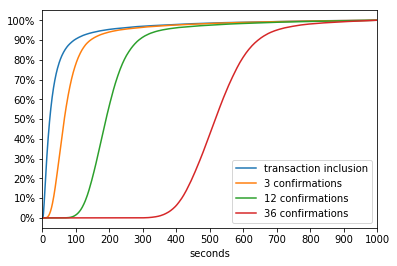

In [4]:
#!/usr/bin/python3
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

TXS_LOG = "/kaggle/input/ethereum-network-measurement/transactions.csv/transactions.csv"

dtypes = {
        'LocalTimeStamp'    : 'object',
        'Hash'              : 'object',
        'GasLimit'          : 'object',
        'GasPrice'          : 'object',
        'Value'             : 'object',
        'Nonce'             : 'object',
        'MsgType'           : 'object',
        'Cost'              : 'object',
        'Size'              : 'object',
        'To'                : 'object',
        'From'              : 'object',
        'ValidityErr'       : 'object',
        'CapturedLocally'   : 'object',
        'GasUsed'           : 'object',
        'InMainBlock'       : 'object',
        'InUncleBlocks'     : 'object',
        'InOrder'           : 'object',
        'NeverCommitting'    : 'object',
        'CommitTime0'       : 'float',
        'CommitTime3'       : 'float',
        'CommitTime12'      : 'float',
        'CommitTime36'      : 'float',
        }

# DUE TO KAGGLE'S RAM LIMIT
# we drop 3/4 of all txs and perfrom this metric only on one quarter of them (5,000,000 out of ~ 20,000,000)
# run this metric on a machine with RAM big enough if you want to cover all of them
txs = pd.read_csv(TXS_LOG, skiprows=1, engine = 'python', nrows=5000000, 
    names=['LocalTimeStamp','Hash','GasLimit','GasPrice','Value','Nonce','MsgType',
            'Cost','Size','To','From','ValidityErr','CapturedLocally','GasUsed',
            'InMainBlock','InUncleBlocks','InOrder','NeverCommitting',
            'CommitTime0','CommitTime3','CommitTime12','CommitTime36'],
            usecols=['Hash','CommitTime0','CommitTime3','CommitTime12','CommitTime36','CapturedLocally'],
            dtype=dtypes)

# drop txs that were not capture locally  
# leave only those that have all commitTimes set (i.e. drop the latest txs for which
# we do not have blocks)
# drop the txs from the beginning of measurement, for which we captured blocks before them
# this drop is only cosmetical as it drops so few txs that the medians and even means change by 0.01s.
condition = txs[   (txs['CapturedLocally'] != "True") | 
    (txs['CommitTime0'].isnull()) | (txs['CommitTime36'].isnull()) |
    (txs['CommitTime3'].isnull()) | (txs['CommitTime12'].isnull()) |
    (txs['CommitTime0'] < 0) ].index

txs.drop(condition , inplace=True)

s_c0 = txs[txs.CommitTime0.notnull()].CommitTime0   #check
s_c3 = txs[txs.CommitTime3.notnull()].CommitTime3   #check
s_c12 = txs[txs.CommitTime12.notnull()].CommitTime12   #check
s_c36 = txs[txs.CommitTime36.notnull()].CommitTime36   #check

bin_seq = list(range(0,1000,1))   #TODO CHANGE !!!  set to  max CommitTIme .. eg 1000
fig, ax = plt.subplots()

counts_c0, bin_edges_c0 = np.histogram (s_c0, bins=bin_seq)
cdf_c0 = np.cumsum (counts_c0)
linec0, = ax.plot (bin_edges_c0[1:], cdf_c0/cdf_c0[-1], label='transaction inclusion')

counts_c3, bin_edges_c3 = np.histogram (s_c3, bins=bin_seq)
cdf_c3 = np.cumsum (counts_c3)
linec3, = ax.plot (bin_edges_c3[1:], cdf_c3/cdf_c3[-1], label='3 confirmations')

counts_c12, bin_edges_c12 = np.histogram (s_c12, bins=bin_seq)
cdf_c12 = np.cumsum (counts_c12)
linec12, = ax.plot (bin_edges_c12[1:], cdf_c12/cdf_c12[-1], label='12 confirmations')

counts_c36, bin_edges_c36 = np.histogram (s_c36, bins=bin_seq)
cdf_c36 = np.cumsum (counts_c36)
linec36, = ax.plot (bin_edges_c36[1:], cdf_c36/cdf_c36[-1], label='36 confirmations')


plt.xlabel('seconds')
plt.yticks(np.arange(0, 1.1, step=0.1),['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
#
#plt.xscale('symlog')
ax.set_xlim(left=0)
ax.set_xlim(right=1000)
#
nums = [0,100,200,300,400,500,600,700,800,900,1000]
labels = ['0','100','200','300','400','500','600','700','800','900','1000']

plt.xticks(nums, labels)

ax.legend()
##LOCAL show
plt.show()


# geo position vs block reception time (4)

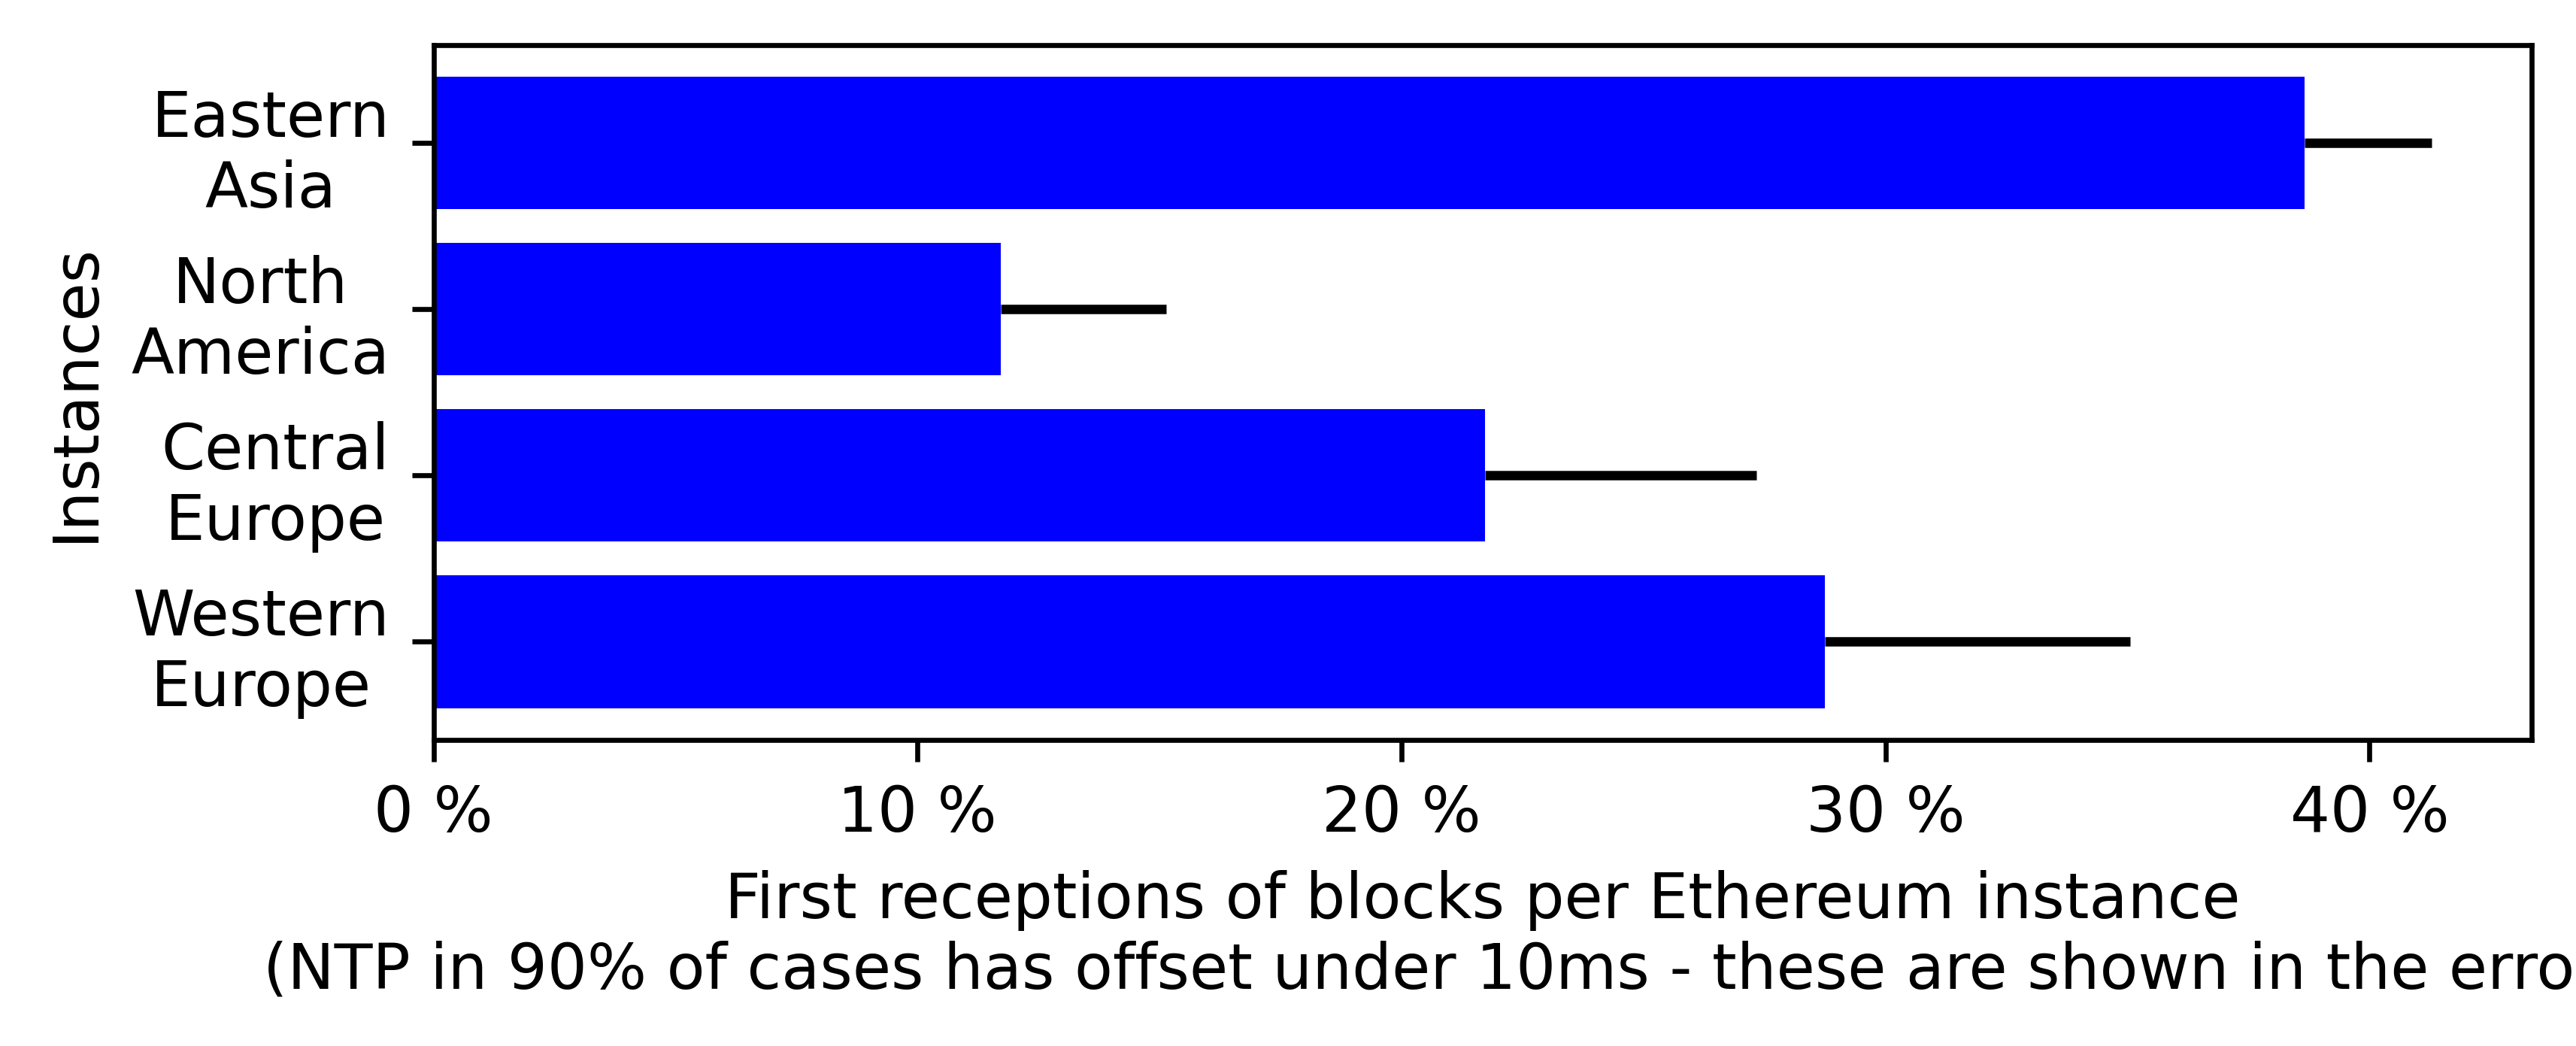

In [1]:
import pandas as pd
import numpy as np
import sys
import os
from pathlib import Path
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

BLOCKS_LOG = "blocks-propagation-times.csv"

dtypes_blocks_propag_times_v3 = {
        'BlockHash'         : 'object',
        'Number'            : 'Int64',
        'BlockType'         : 'object',
        'AngainorTimeStamp' : 'object',
        'FalconTimeStamp'   : 'object',
        'S1USTimeStamp'     : 'object',
        'S2CNTimeStamp'     : 'object',
        'FirstObservation'  : 'object',
        'AngainorDiff'      : 'float',
        'FalconDiff'        : 'float',
        'S1USDiff'          : 'float',
        'S2CNDiff'          : 'float',
        'MiningPool'        : 'object',
        'NumTransactions'   : 'Int64',
        'SameMinerSeqLen'   : 'Int64',
        'PositionInsideSeq' : 'Int64',
        'Difficulty'        : 'Int64',   
        'BlockSize'         : 'Int64',
        'InterblockTime'    : 'float',   
        'InterblockTimePerPool' : 'float',
        }

#load blocks
blocks = pd.read_csv(BLOCKS_LOG, skiprows=1,
    names=['BlockHash','Number','BlockType','AngainorTimeStamp','FalconTimeStamp',
        'S1USTimeStamp','S2CNTimeStamp','FirstObservation',
        'AngainorDiff','FalconDiff','S1USDiff','S2CNDiff',
        'MiningPool','NumTransactions','SameMinerSeqLen','PositionInsideSeq',
        'Difficulty','BlockSize','InterblockTime','InterblockTimePerPool'],
    dtype=dtypes_blocks_propag_times_v3)

first_receptions_per_instance = []
first_receptions_per_instance_10ms = [] # 90% of ntp has tolerance under 10ms

num_blocks = len(blocks)
first_receptions_sum = 0

for i in ['AngainorDiff', 'FalconDiff', 'S1USDiff', 'S2CNDiff']:
    first_receptions = len(blocks[(blocks[i] == 0 )])
    #print("first receptions:", first_receptions, round(first_receptions/num_blocks*100,2), " %", i)
    first_receptions_per_instance.append(len( blocks[  (blocks[i] == 0 ) ] ))
    first_receptions_per_instance_10ms.append(len( blocks[ (blocks[i] > 0 ) & (blocks[i] <= 0.01 ) ] ))

    first_receptions_sum = first_receptions_sum + first_receptions
    
#print("blocks:", len(blocks))
#print("first receptions:", first_receptions_sum,
#    "--- (", first_receptions_sum-len(blocks), "times a new block was received on more machines at the same time)")

x = ['Western\nEurope', 'Central\nEurope', 'North\nAmerica', 'Eastern\nAsia']
x_pos = [i for i, _ in enumerate(x)]
figure(num=None, figsize=(6, 2), dpi=600, facecolor='w', edgecolor='k')
bar1 = plt.barh(x_pos, first_receptions_per_instance, color='blue', xerr=[(0,0,0,0),first_receptions_per_instance_10ms])

plt.ylabel("Instances")
plt.xlabel("First receptions of blocks per Ethereum instance\n\
    (NTP in 90% of cases has offset under 10ms - these are shown in the error bars)")

plt.yticks(x_pos, x, multialignment="center")
nums = [0,num_blocks/10,num_blocks/5,num_blocks*0.3,num_blocks*0.4]
labels = ['0 %','10 %','20 %','30 %','40 %']
plt.xticks(nums, labels)

plt.show()


# Which geo-location receives blocks first

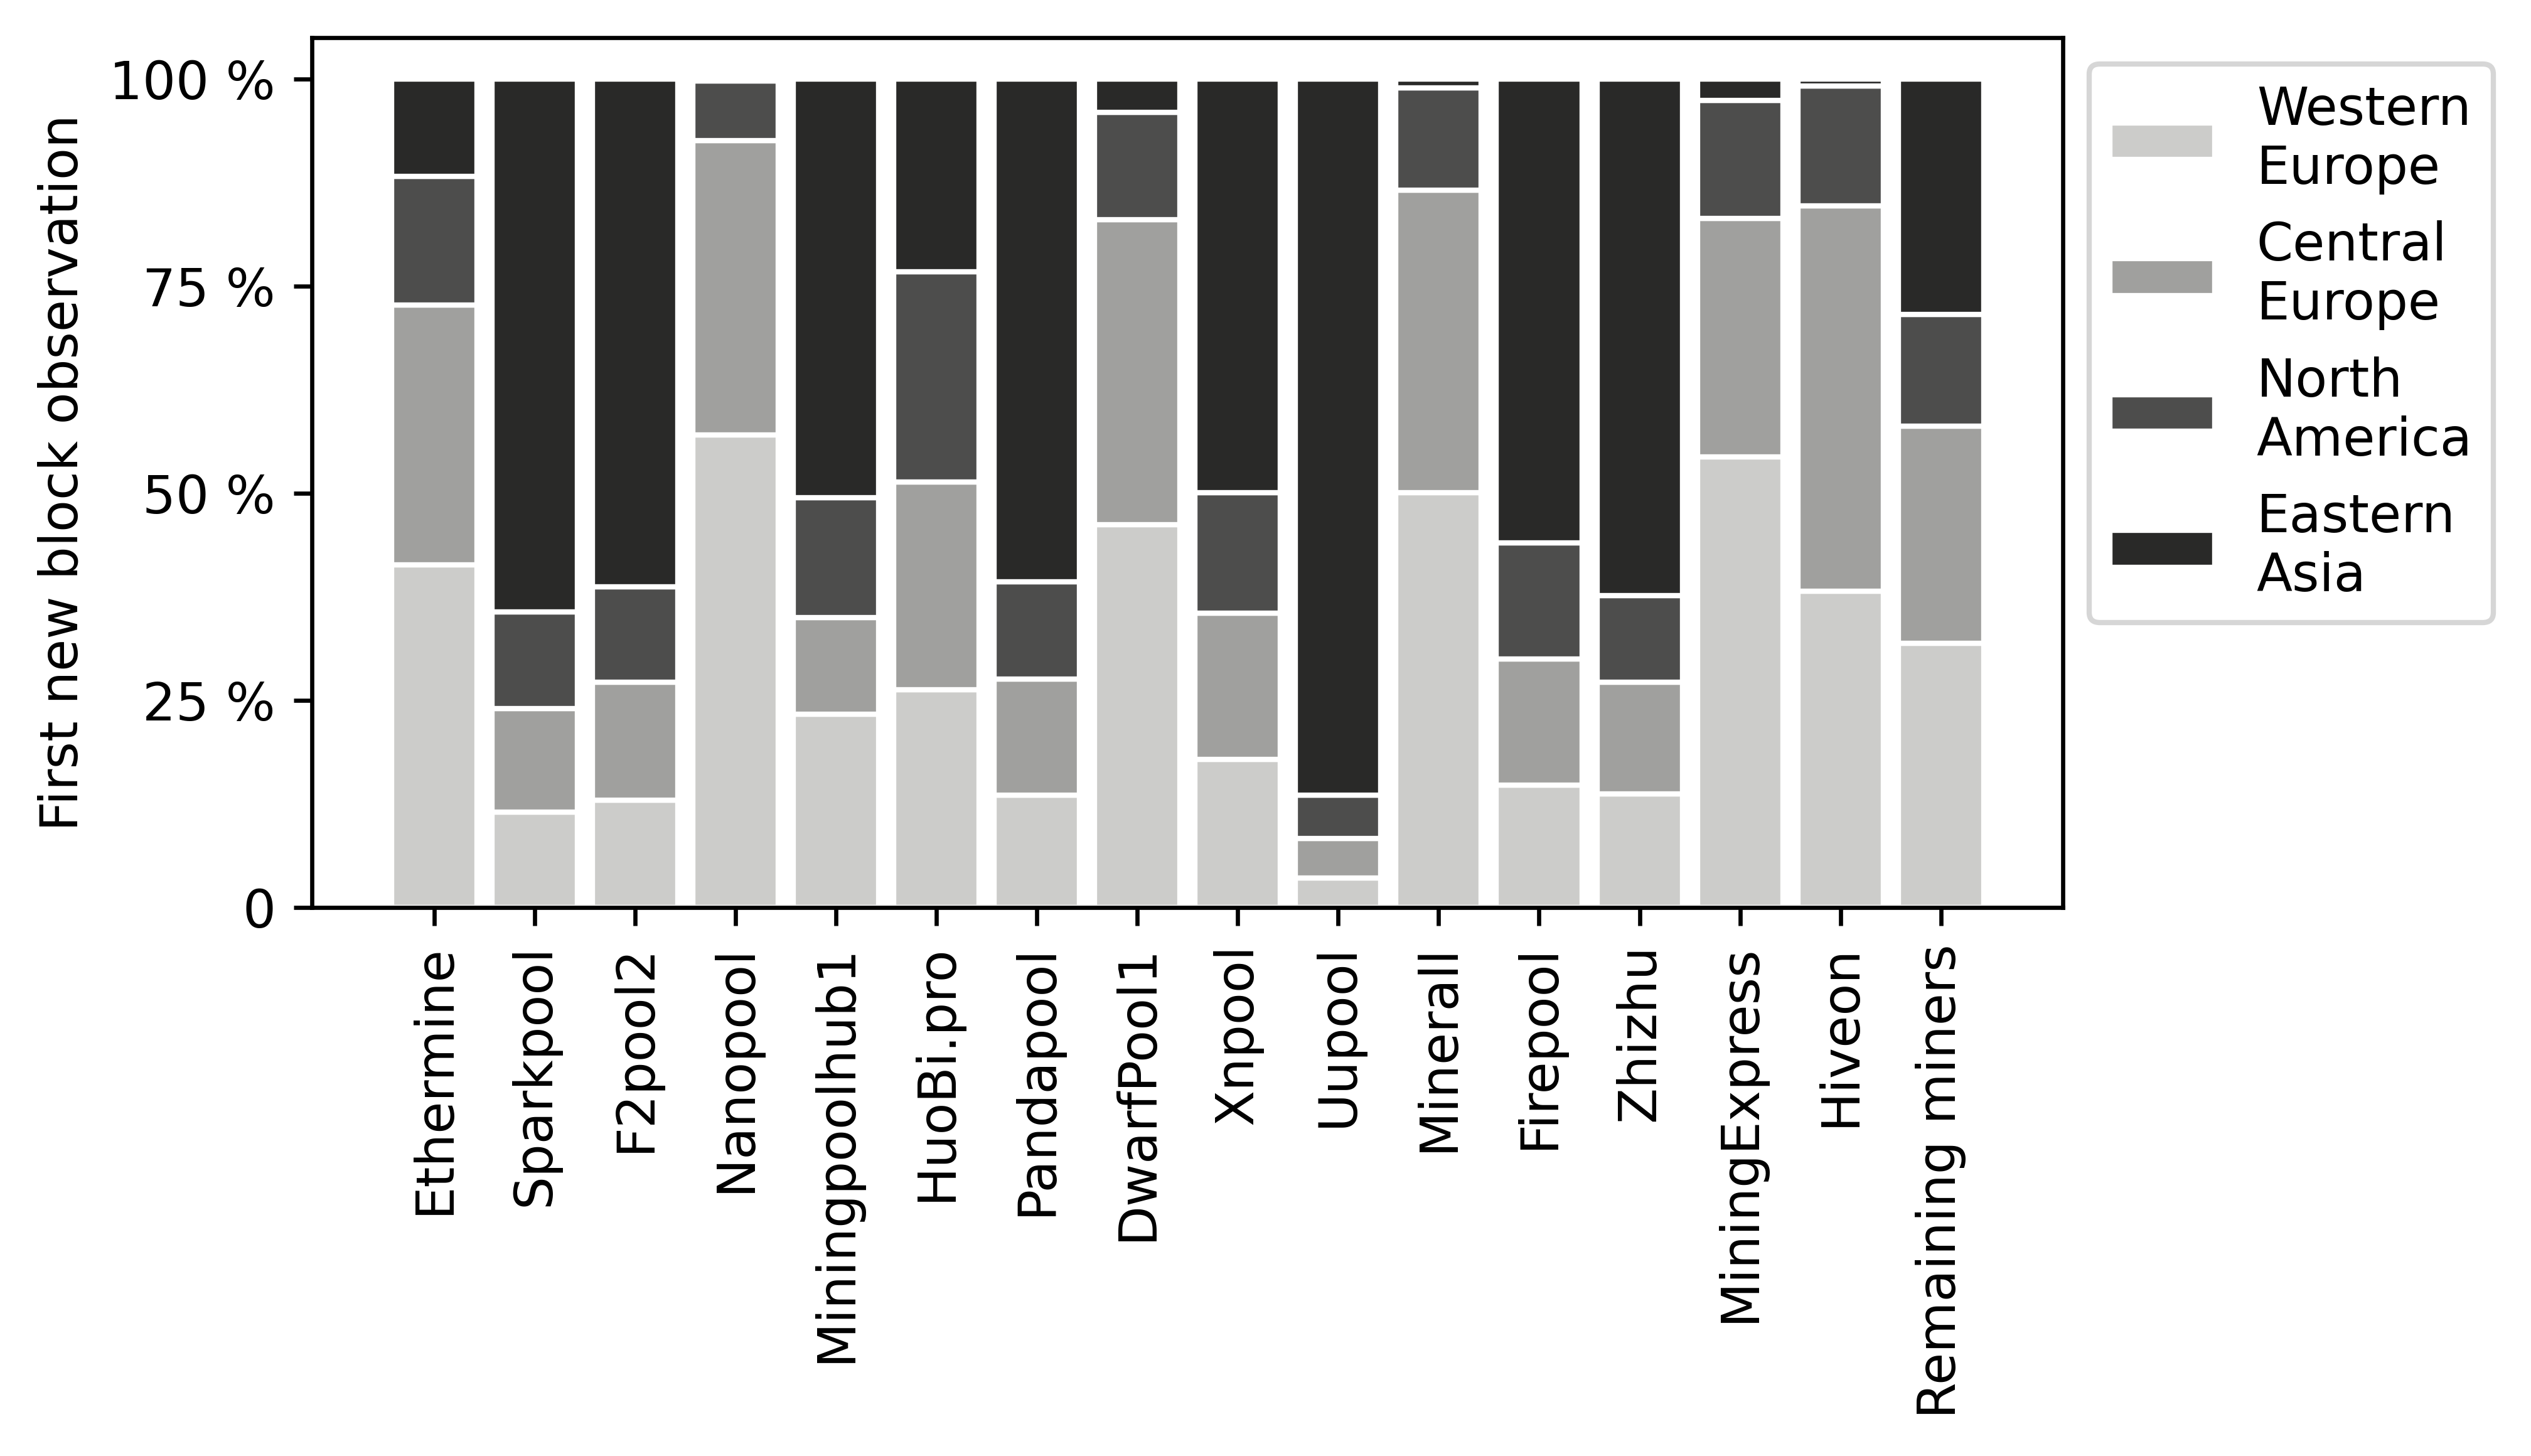

In [5]:
import pandas as pd
import numpy as np
import sys
import os

from numpy import ma
from matplotlib import scale as mscale
from matplotlib import transforms as mtransforms
from matplotlib.pyplot import figure
from matplotlib.ticker import FixedFormatter, FixedLocator
import matplotlib.pyplot as plt

#print all columns (not to cut the tail)
pd.set_option('display.expand_frame_repr', False)

BLOCKS_LOG = "blocks-propagation-times.csv"

dtypes_blocks_propag_times_v3 = {
        'BlockHash'         : 'object',
        'Number'            : 'Int64',
        'BlockType'         : 'object',
        'AngainorTimeStamp' : 'object',
        'FalconTimeStamp'   : 'object',
        'S1USTimeStamp'     : 'object',
        'S2CNTimeStamp'     : 'object',
        'FirstObservation'  : 'object',
        'AngainorDiff'      : 'float',
        'FalconDiff'        : 'float',
        'S1USDiff'          : 'float',
        'S2CNDiff'          : 'float',
        'MiningPool'        : 'object',
        'NumTransactions'   : 'Int64',
        'SameMinerSeqLen'   : 'Int64',
        'PositionInsideSeq' : 'Int64',
        'Difficulty'        : 'Int64',   
        'BlockSize'         : 'Int64',
        'InterblockTime'    : 'float',   
        'InterblockTimePerPool' : 'float',
        }

#load blocks
blocks = pd.read_csv(BLOCKS_LOG, skiprows=1,
    names=['BlockHash','Number','BlockType','AngainorTimeStamp','FalconTimeStamp',
        'S1USTimeStamp','S2CNTimeStamp','FirstObservation',
        'AngainorDiff','FalconDiff','S1USDiff','S2CNDiff',
        'MiningPool','NumTransactions','SameMinerSeqLen','PositionInsideSeq',
        'Difficulty','BlockSize','InterblockTime','InterblockTimePerPool'],
    dtype=dtypes_blocks_propag_times_v3)

top_15_pools = ['Ethermine', 'Sparkpool', 'f2pool2', 'Nanopool', 'miningpoolhub1',
    'HuoBi.pro', 'pandapool', 'DwarfPool1', 'xnpool', 'uupool', 'Minerall', 'firepool',
    'zhizhu', 'MiningExpress', 'Hiveon',]

# for each pool out of top-15
# set 'MiningPool' to  "remaining" 
blocks.loc[~blocks.MiningPool.isin(top_15_pools), 'MiningPool'] = 'remaining'

#  crate a data framame with selected 15 pools (in order by power)  +  'remaining' (pools)
min_pools_list = ['Ethermine', 'Sparkpool', 'f2pool2', 'Nanopool', 'miningpoolhub1',
    'HuoBi.pro', 'pandapool', 'DwarfPool1', 'xnpool', 'uupool', 'Minerall', 'firepool',
    'zhizhu', 'MiningExpress', 'Hiveon', 'remaining']
min_pools = pd.DataFrame(min_pools_list, columns =['MiningPool'])
min_pools.set_index('MiningPool', inplace=True)

min_pools = min_pools.assign(
    pt = 0, cz = 0, us = 0, cn = 0,
    pt10ms = 0, cz10ms = 0, us10ms = 0, cn10ms = 0)

for i in blocks.index:
    currentMiner = blocks.at[i,'MiningPool']
    
    if blocks.at[i,'AngainorDiff'] <= 0:
        min_pools.at[currentMiner, 'pt'] = min_pools.at[currentMiner, 'pt'] + 1
    if blocks.at[i,'FalconDiff'] <= 0:
        min_pools.at[currentMiner, 'cz'] = min_pools.at[currentMiner, 'cz'] + 1
    if blocks.at[i,'S1USDiff'] <= 0:
        min_pools.at[currentMiner, 'us'] = min_pools.at[currentMiner, 'us'] + 1
    if blocks.at[i,'S2CNDiff'] <= 0:
        min_pools.at[currentMiner, 'cn'] = min_pools.at[currentMiner, 'cn'] + 1
    if blocks.at[i,'AngainorDiff'] <= 0.01:
        min_pools.at[currentMiner, 'pt10ms'] = min_pools.at[currentMiner, 'pt10ms'] + 1
    if blocks.at[i,'FalconDiff'] <= 0.01:
        min_pools.at[currentMiner, 'cz10ms'] = min_pools.at[currentMiner, 'cz10ms'] + 1
    if blocks.at[i,'S1USDiff'] <= 0.01:
        min_pools.at[currentMiner, 'us10ms'] = min_pools.at[currentMiner, 'us10ms'] + 1
    if blocks.at[i,'S2CNDiff'] <= 0.01:
        min_pools.at[currentMiner, 'cn10ms'] = min_pools.at[currentMiner, 'cn10ms'] + 1

#set figure size
figure(num=None, figsize=(6, 3), dpi=600, facecolor='w', edgecolor='k')

def print_bar_graph(min_pools, precision10ms):
    if precision10ms == False:
        PT = 'pt'
        CZ = 'cz'
        US = 'us'
        CN = 'cn'
    else:
        PT = 'pt10ms'
        CZ = 'cz10ms'
        US = 'us10ms'
        CN = 'cn10ms'

    #only 15 biggest pools + 1 (remaining)  = 16
    #min_pools = min_pools[:16]  #  set 15   if you want withou REMAINING
    r = list(range(0,16))        #  set 15   if you want withou REMAINING

    # From raw value to percentage
    totals = [i+j+k+l for i,j,k,l in zip(min_pools[PT].reset_index(drop=True),
        min_pools[CZ].reset_index(drop=True), min_pools[US].reset_index(drop=True),
        min_pools[CN].reset_index(drop=True))]

    pt = [i / j * 100 for i,j in zip(min_pools[PT].reset_index(drop=True), totals)]
    cz = [i / j * 100 for i,j in zip(min_pools[CZ].reset_index(drop=True), totals)]
    us = [i / j * 100 for i,j in zip(min_pools[US].reset_index(drop=True), totals)]
    cn = [i / j * 100 for i,j in zip(min_pools[CN].reset_index(drop=True), totals)]

    barWidth = 0.85
    names = ('Ethermine','Sparkpool','F2pool2','Nanopool',
        'Miningpoolhub1', 'HuoBi.pro', 'Pandapool', 'DwarfPool1',
        'Xnpool', 'Uupool', 'Minerall', 'Firepool',
        'Zhizhu', 'MiningExpress', 'Hiveon', 'Remaining miners')

    plt.bar(r, pt, color='#ccccca', edgecolor='white', width=barWidth, label="Western\nEurope")
    plt.bar(r, cz, bottom=pt, color='#a0a09e', edgecolor='white', width=barWidth, label="Central\nEurope")
    plt.bar(r, us, bottom=[i+j for i,j in zip(pt, cz)], color='#4d4d4c', edgecolor='white',
        width=barWidth, label="North\nAmerica")
    plt.bar(r, cn, bottom=[i+j+k for i,j,k in zip(pt, cz, us)], color='#292928',
        edgecolor='white', width=barWidth, label="Eastern\nAsia")

    plt.xticks(r, names, rotation=90)
    plt.ylabel("First new block observation")
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    plt.ylim(bottom=0)
    plt.yticks([0,25,50,75,100], ['0','25 %','50 %','75 %','100 %'])
    plt.show()

print_bar_graph(min_pools, True)


In [7]:
min_pools.to_excel('min_pools.xlsx',index = True)

# Empty blocks per pool

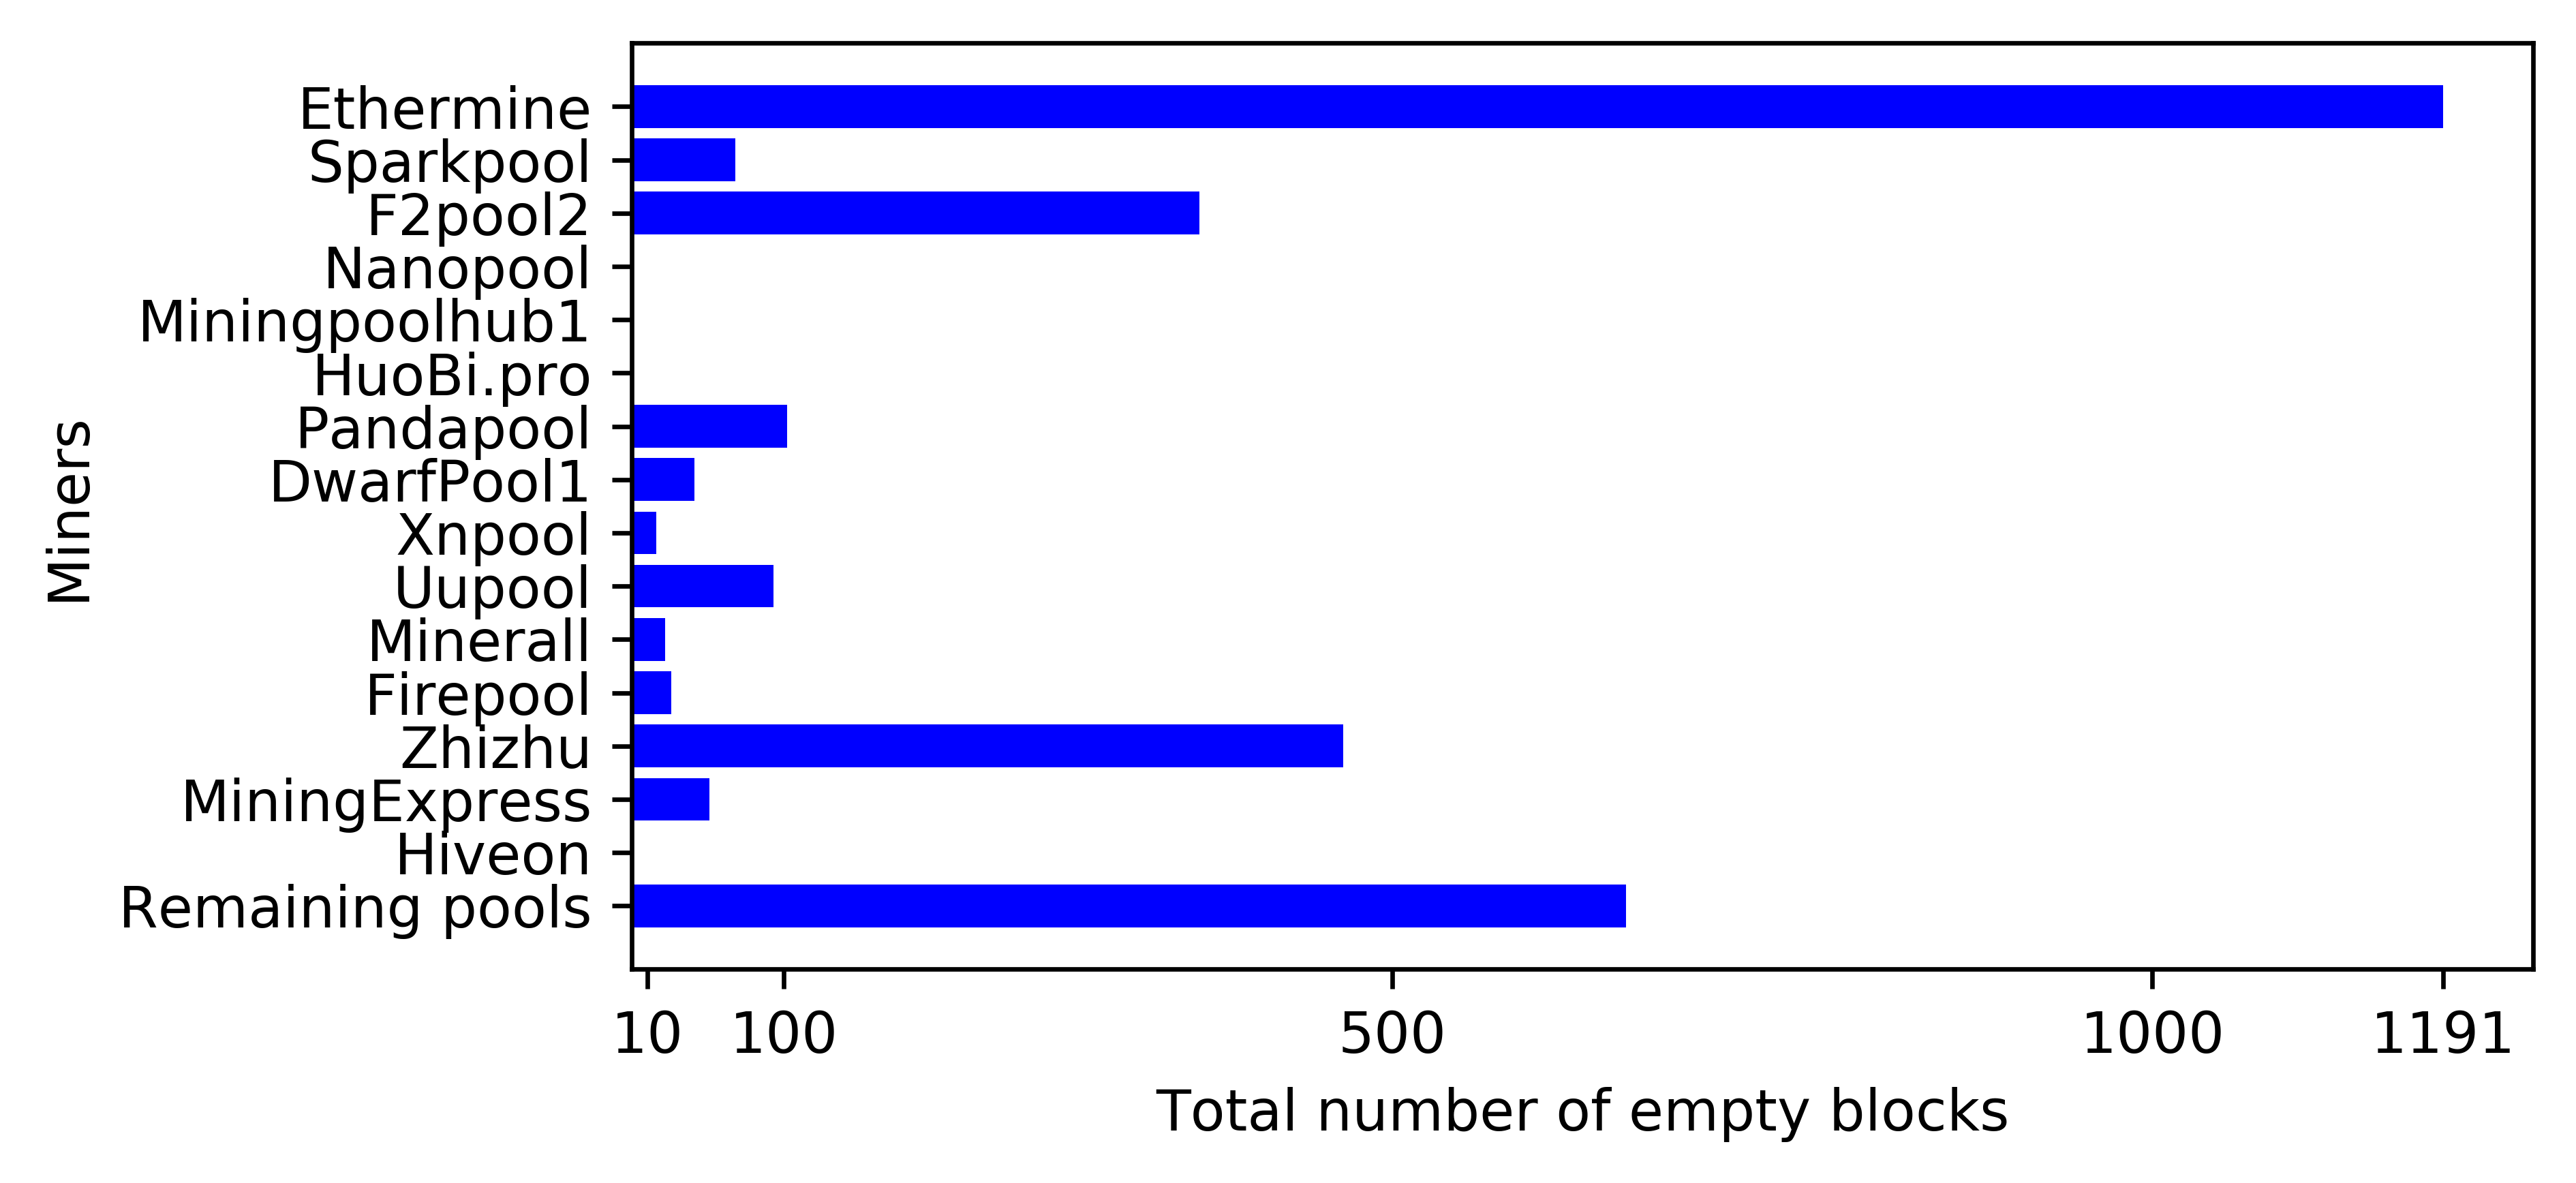

                  blocks  empty_blocks emptyVStotBlocks
Pool                                                   
Ethermine          54871          1191            2.17%
Sparkpool          49574            68            0.14%
f2pool2            27622           373            1.35%
Nanopool           26210             0            0.00%
miningpoolhub1     12162             0            0.00%
HuoBi.pro           4008             0            0.00%
pandapool           3947           102            2.58%
DwarfPool1          3760            41            1.09%
xnpool              2895            16            0.55%
uupool              2879            93            3.23%
Minerall            2675            22            0.82%
firepool            2643            26            0.98%
zhizhu              1836           468           25.49%
MiningExpress       1754            51            2.91%
Hiveon              1667             1            0.06%
ALL-OTHER-MINERS   18168           654          

In [7]:
import pandas as pd
import numpy as np
import sys
import os
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

pd.set_option('display.expand_frame_repr', False)

BLOCKS = "/kaggle/input/ethereum-network-measurement/blocks.csv/blocks.csv"

dtypes_blocks = {
        'LocalTimeStamp'    : 'object',
        'BlockHash'     : 'object',
        'Number'        : 'object',
        'GasLimit'      : 'object',
        'GasUsed'       : 'object',
        'Difficulty'    : 'object',
        'Time'          : 'object',
        'Coinbase'      : 'object',
        'ParentHash'    : 'object',
        'UncleHash'     : 'object',
        'BlockSize'     : 'object',
        'ListOfTxs'     : 'object',
        'ListOfUncles'  : 'object',
        'CapturedLocally'   : 'bool',
        'BlockType'         : 'object',
        'ForkLength'    : 'int',
        }

blocks = pd.read_csv(BLOCKS, skiprows=1, engine = 'python',
    names=['LocalTimeStamp','BlockHash','Number','GasLimit','GasUsed','Difficulty','Time',
    'Coinbase','ParentHash','UncleHash','BlockSize','ListOfTxs','ListOfUncles',
    'CapturedLocally','BlockType','ForkLength'],
    usecols=['BlockHash','Number', 'Coinbase','BlockType', 'ListOfTxs'],
    dtype=dtypes_blocks)

# assign number of txs to every block
blocks = blocks.assign(NumTxs = 0)
for id_block, row in blocks.iterrows():
    try:
        txs = row['ListOfTxs'].split(";")
        #remove empty lines (there is always one empty line at the end of the list)
        txs = list(filter(None, txs))
        num_txs_in_uncle_block = len(txs)
    except AttributeError:
        num_txs_in_uncle_block = 0
    
    blocks.at[id_block, 'NumTxs'] = num_txs_in_uncle_block

num_total = len(blocks)
num_with_zero_txs = len(blocks[blocks.NumTxs == 0])

num_main_total = len(blocks[blocks.BlockType == "Main"])
num_main_with_zero_txs = len(blocks[(blocks.BlockType == "Main") & (blocks.NumTxs == 0)])

proportion = num_with_zero_txs / num_total
#print("BLOCKS:", num_total, "EMPTY BLOCKS:", num_with_zero_txs,
#    "proportion of empty blocks:", proportion)

####### ASSIGN
blocks = blocks.assign(MiningPool = "ALL-OTHER-MINERS")
blocks.loc[blocks['Coinbase'] == "0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8", 'MiningPool'] = "Ethermine"
blocks.loc[blocks['Coinbase'] == "0x5A0b54D5dc17e0AadC383d2db43B0a0D3E029c4c", 'MiningPool'] = "Sparkpool"
blocks.loc[blocks['Coinbase'] == "0x829BD824B016326A401d083B33D092293333A830", 'MiningPool'] = "f2pool2"
blocks.loc[blocks['Coinbase'] == "0x52bc44d5378309EE2abF1539BF71dE1b7d7bE3b5", 'MiningPool'] = "Nanopool"
blocks.loc[blocks['Coinbase'] == "0xb2930B35844a230f00E51431aCAe96Fe543a0347", 'MiningPool'] = "miningpoolhub1"
blocks.loc[blocks['Coinbase'] == "0x1B5B5906306c96b842dc03105E3b38636A4EDa0b", 'MiningPool'] = "HuoBi.pro"
blocks.loc[blocks['Coinbase'] == "0x2a5994b501E6A560e727b6C2DE5D856396aaDd38", 'MiningPool'] = "pandapool"
blocks.loc[blocks['Coinbase'] == "0x2a65Aca4D5fC5B5C859090a6c34d164135398226", 'MiningPool'] = "DwarfPool1"
blocks.loc[blocks['Coinbase'] == "0x005e288D713a5fB3d7c9cf1B43810A98688C7223", 'MiningPool'] = "xnpool"
blocks.loc[blocks['Coinbase'] == "0xD224cA0c819e8E97ba0136B3b95ceFf503B79f53", 'MiningPool'] = "uupool"
blocks.loc[blocks['Coinbase'] == "0x09ab1303d3CcAF5f018CD511146b07A240c70294", 'MiningPool'] = "Minerall"
blocks.loc[blocks['Coinbase'] == "0x35F61DFB08ada13eBA64Bf156B80Df3D5B3a738d", 'MiningPool'] = "firepool"
blocks.loc[blocks['Coinbase'] == "0x04668Ec2f57cC15c381b461B9fEDaB5D451c8F7F", 'MiningPool'] = "zhizhu"
blocks.loc[blocks['Coinbase'] == "0x06B8C5883Ec71bC3f4B332081519f23834c8706E", 'MiningPool'] = "MiningExpress"
blocks.loc[blocks['Coinbase'] == "0x4C549990A7eF3FEA8784406c1EECc98bF4211fA5", 'MiningPool'] = "Hiveon"

#  crate a data framame   with  one min. pool  for each row
min_pools_list = blocks['MiningPool'].unique() 

min_pools = pd.DataFrame(min_pools_list, columns =['Pool'])
min_pools.set_index('Pool', inplace=True)

counts_of_blcks_per_pool = blocks['MiningPool'].value_counts(dropna=False)

empty_blocks = blocks[ blocks['NumTxs'] == 0 ]
not_empty_blocks = blocks[ blocks['NumTxs'] != 0 ]

min_pools = min_pools.assign(blocks = np.nan, empty_blocks = np.nan,
    emptyVStotBlocks = np.nan)

for i in min_pools.index:
    num_empty = len(empty_blocks[empty_blocks['MiningPool'] == i])
    min_pools.at[i, 'empty_blocks'] = num_empty
    num_blocks = len(blocks[blocks['MiningPool'] == i])
    min_pools.at[i, 'blocks'] = num_blocks
    min_pools.at[i, 'emptyVStotBlocks'] = num_empty / num_blocks

min_pools['blocks'] = min_pools['blocks'].apply(np.int64)
min_pools['empty_blocks'] = min_pools['empty_blocks'].apply(np.int64)

min_pools = min_pools.reindex(['Ethermine', 'Sparkpool', 'f2pool2', 'Nanopool', 'miningpoolhub1',
    'HuoBi.pro', 'pandapool', 'DwarfPool1', 'xnpool', 'uupool', 'Minerall', 'firepool',
    'zhizhu', 'MiningExpress', 'Hiveon','ALL-OTHER-MINERS'])

### select except ALL-OTHER
#pools_selection = min_pools[   (min_pools.index != "ALL-OTHER-MINERS")      ]
pools_selection = min_pools

x = ['Ethermine', 'Sparkpool', 'F2pool2', 'Nanopool', 'Miningpoolhub1',
    'HuoBi.pro', 'Pandapool', 'DwarfPool1', 'Xnpool', 'Uupool', 'Minerall', 'Firepool',
    'Zhizhu', 'MiningExpress', 'Hiveon','Remaining pools']

s_pools = pools_selection.empty_blocks

s_pools = np.flip(s_pools)  
x.reverse()

x_pos = [i for i, _ in enumerate(x)]

#set figure size
figure(num=None, figsize=(6, 3), dpi=600, facecolor='w', edgecolor='k')
#fig.set_size_inches(6,3, forward=True)


plt.barh(x_pos, s_pools, color='blue')
plt.ylabel("Miners")
plt.xlabel("Total number of empty blocks")
#plt.title("Empty blocks of the 15 biggest mining entities")

plt.yticks(x_pos, x)

nums = [10,100,500,1000,1191]
labels = ['10','100','500','1000','1191']

plt.xticks(nums, labels)

plt.show()

#print
min_pools['emptyVStotBlocks'] = pd.Series(["{0:.2f}%".format(val * 100) for val in min_pools['emptyVStotBlocks']], index = min_pools.index)
print (min_pools)


# Consecutive blocks per mining pool

blocks total:   216671
main blocks total:   201086
LEN-8 Ethermine 7493772 7493779
LEN-9 Sparkpool 7498853 7498861
LEN-8 Sparkpool 7511434 7511441
LEN-8 Ethermine 7531555 7531562
LEN-8 Ethermine 7577037 7577044
LEN-8 Ethermine 7627781 7627788
LEN-9 Sparkpool 7633236 7633244


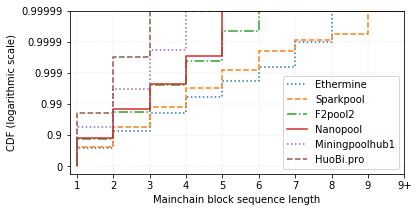

In [8]:
import pandas as pd
import numpy as np
import sys
import os

from numpy import ma
from matplotlib import scale as mscale
from matplotlib import transforms as mtransforms
from matplotlib.ticker import FixedFormatter, FixedLocator
from matplotlib.pyplot import figure

import matplotlib.pyplot as plt

#print all columns (not to cut the tail)
pd.set_option('display.expand_frame_repr', False)

BLOCKS = "/kaggle/input/ethereum-network-measurement/blocks.csv/blocks.csv"

dtypes_blocks = {
        'LocalTimeStamp'    : 'object',
        'BlockHash'     : 'object',
        'Number'        : 'object',
        'GasLimit'      : 'object',
        'GasUsed'       : 'object',
        'Difficulty'    : 'object',
        'Time'          : 'object',
        'Coinbase'      : 'object',
        'ParentHash'    : 'object',
        'UncleHash'     : 'object',
        'BlockSize'     : 'object',
        'ListOfTxs'     : 'object',
        'ListOfUncles'  : 'object',
        'CapturedLocally'   : 'bool',
        'BlockType'         : 'object',
        'ForkLength'    : 'int',
        }

blocks = pd.read_csv(BLOCKS, skiprows=1, engine = 'python',
    names=['LocalTimeStamp','BlockHash','Number','GasLimit','GasUsed','Difficulty','Time',
    'Coinbase','ParentHash','UncleHash','BlockSize','ListOfTxs','ListOfUncles',
    'CapturedLocally','BlockType','ForkLength'],
    usecols=['BlockHash','Number', 'Coinbase','BlockType'],
    dtype=dtypes_blocks)

len_blocks = len(blocks)
print("blocks total:  ", len_blocks)

####### ASSIGN
blocks = blocks.assign(MiningPool = "ALL-OTHER-MINERS", probNext = np.nan, SameMinSeq = np.nan)
blocks.loc[blocks['Coinbase'] == "0xEA674fdDe714fd979de3EdF0F56AA9716B898ec8", 'MiningPool'] = "Ethermine"
blocks.loc[blocks['Coinbase'] == "0x5A0b54D5dc17e0AadC383d2db43B0a0D3E029c4c", 'MiningPool'] = "Sparkpool"
blocks.loc[blocks['Coinbase'] == "0x829BD824B016326A401d083B33D092293333A830", 'MiningPool'] = "f2pool2"
blocks.loc[blocks['Coinbase'] == "0x52bc44d5378309EE2abF1539BF71dE1b7d7bE3b5", 'MiningPool'] = "Nanopool"
blocks.loc[blocks['Coinbase'] == "0xb2930B35844a230f00E51431aCAe96Fe543a0347", 'MiningPool'] = "miningpoolhub1"
blocks.loc[blocks['Coinbase'] == "0x1B5B5906306c96b842dc03105E3b38636A4EDa0b", 'MiningPool'] = "HuoBi.pro"
blocks.loc[blocks['Coinbase'] == "0x2a5994b501E6A560e727b6C2DE5D856396aaDd38", 'MiningPool'] = "pandapool"
blocks.loc[blocks['Coinbase'] == "0x2a65Aca4D5fC5B5C859090a6c34d164135398226", 'MiningPool'] = "DwarfPool1"
blocks.loc[blocks['Coinbase'] == "0x005e288D713a5fB3d7c9cf1B43810A98688C7223", 'MiningPool'] = "xnpool"
blocks.loc[blocks['Coinbase'] == "0xD224cA0c819e8E97ba0136B3b95ceFf503B79f53", 'MiningPool'] = "uupool"
blocks.loc[blocks['Coinbase'] == "0x09ab1303d3CcAF5f018CD511146b07A240c70294", 'MiningPool'] = "Minerall"
blocks.loc[blocks['Coinbase'] == "0x35F61DFB08ada13eBA64Bf156B80Df3D5B3a738d", 'MiningPool'] = "firepool"
blocks.loc[blocks['Coinbase'] == "0x04668Ec2f57cC15c381b461B9fEDaB5D451c8F7F", 'MiningPool'] = "zhizhu"
blocks.loc[blocks['Coinbase'] == "0x06B8C5883Ec71bC3f4B332081519f23834c8706E", 'MiningPool'] = "MiningExpress"
blocks.loc[blocks['Coinbase'] == "0x4C549990A7eF3FEA8784406c1EECc98bF4211fA5", 'MiningPool'] = "Hiveon"
blocks.loc[blocks['Coinbase'] == "0x84A0d77c693aDAbE0ebc48F88b3fFFF010577051", 'MiningPool'] = "(0x84A0d7..)"
blocks.loc[blocks['Coinbase'] == "0xAA5c4244F05c92781C4F259913319d8ba1aCF05E", 'MiningPool'] = "(0xAA5c42..)"
blocks.loc[blocks['Coinbase'] == "0x00192Fb10dF37c9FB26829eb2CC623cd1BF599E8", 'MiningPool'] = "2miners"
blocks.loc[blocks['Coinbase'] == "0x52E44f279f4203Dcf680395379E5F9990A69f13c", 'MiningPool'] = "bw"
blocks.loc[blocks['Coinbase'] == "0x6a7a43BE33ba930fE58F34E07D0ad6bA7ADB9B1F", 'MiningPool'] = "Coinotron"
blocks.loc[blocks['Coinbase'] == "0x858fDEC2da9fA3CD3d97B8Bd1af98E9249D33613", 'MiningPool'] = "(0x858fDE..)"
blocks.loc[blocks['Coinbase'] == "0x002e08000acbbaE2155Fab7AC01929564949070d", 'MiningPool'] = "2minerssolo"

class CloseToOne(mscale.ScaleBase):
    name = 'close_to_one'

    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self)
        self.nines = kwargs.get('nines', 5)

    def get_transform(self):
        return self.Transform(self.nines)

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(FixedLocator(
                np.array([1-10**(-k) for k in range(1+self.nines)])))
        axis.set_major_formatter(FixedFormatter(
                [str(1-10**(-k)) for k in range(1+self.nines)]))

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return vmin, min(1 - 10**(-self.nines), vmax)

    class Transform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def __init__(self, nines):
            mtransforms.Transform.__init__(self)
            self.nines = nines

        def transform_non_affine(self, a):
            masked = ma.masked_where(a > 1-10**(-1-self.nines), a)
            if masked.mask.any():
                return -ma.log10(1-a)
            else:
                return -np.log10(1-a)

        def inverted(self):
            return CloseToOne.InvertedTransform(self.nines)

    class InvertedTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def __init__(self, nines):
            mtransforms.Transform.__init__(self)
            self.nines = nines

        def transform_non_affine(self, a):
            return 1. - 10**(-a)

        def inverted(self):
            return CloseToOne.Transform(self.nines)

mscale.register_scale(CloseToOne)

#  take only  MAIN blocks from now
main_blocks = blocks[ blocks['BlockType'] == "Main" ]
rec_uncle_blocks = blocks[ blocks['BlockType'] == "Recognized" ]
unrec_forked_blocks = blocks[ blocks['BlockType'] == "Uncle" ]

len_man_blocks = len(main_blocks)
print("main blocks total:  ", len_man_blocks)
counts_of_blcks_per_pool = main_blocks["MiningPool"].value_counts()

#  crate a data framame   with  one min. pool  for each row
min_pools_list = main_blocks['MiningPool'].unique() 

min_pools = pd.DataFrame(min_pools_list, columns =['Pool'])
min_pools.set_index('Pool', inplace=True)

min_pools = min_pools.assign(count = counts_of_blcks_per_pool, countVStotal = np.nan, SameMinSeq = 0,
    seqVScount = np.nan, col_2_4_corel = np.nan,
    seq_1 = 0, seq_2 = 0, seq_3 = 0, seq_4 = 0, seq_5 = 0,
    seq_6 = 0, seq_7 = 0, seq_8 = 0, seq_9 = 0, seq_10 = 0)   #seq_10 means anything over 9,. e.g. 10,11,12..

for i in min_pools.index:
    min_pools.at[i, 'countVStotal'] = min_pools.at[i, 'count'] / len_man_blocks

min_pools = min_pools.sort_values('count', ascending=False)

#  reset index, because we dropped some forks and uncles
main_blocks.reset_index(inplace=True, drop=True)

#loop all  main blocks   (SORTED BY   Num  (ascending))
cur_seq = 1

for i in main_blocks.index:

    if i == 0:
        prevMiner = main_blocks.at[i, 'MiningPool']
        continue

    if main_blocks.at[i, 'MiningPool'] == prevMiner:
        min_pools.at[prevMiner, 'SameMinSeq'] = min_pools.at[prevMiner, 'SameMinSeq'] + 1
        cur_seq = cur_seq + 1
    else:
        if cur_seq == 1:
            min_pools.at[prevMiner, 'seq_1'] = min_pools.at[prevMiner, 'seq_1'] + 1
        elif cur_seq == 2:
            min_pools.at[prevMiner, 'seq_2'] = min_pools.at[prevMiner, 'seq_2'] + 1
        elif cur_seq == 3:
            min_pools.at[prevMiner, 'seq_3'] = min_pools.at[prevMiner, 'seq_3'] + 1
        elif cur_seq == 4:
            min_pools.at[prevMiner, 'seq_4'] = min_pools.at[prevMiner, 'seq_4'] + 1
        elif cur_seq == 5:
            min_pools.at[prevMiner, 'seq_5'] = min_pools.at[prevMiner, 'seq_5'] + 1
        elif cur_seq == 6:
            min_pools.at[prevMiner, 'seq_6'] = min_pools.at[prevMiner, 'seq_6'] + 1
        elif cur_seq == 7:
            min_pools.at[prevMiner, 'seq_7'] = min_pools.at[prevMiner, 'seq_7'] + 1
        elif cur_seq == 8:
            min_pools.at[prevMiner, 'seq_8'] = min_pools.at[prevMiner, 'seq_8'] + 1

            # print    miner and block num
            print("LEN-8", main_blocks.at[i-1, 'MiningPool'], main_blocks.at[i-8, 'Number'],
            main_blocks.at[i-1, 'Number'])

        elif cur_seq == 9:
            min_pools.at[prevMiner, 'seq_9'] = min_pools.at[prevMiner, 'seq_9'] + 1

            # print    miner and block num
            print("LEN-9", main_blocks.at[i-1, 'MiningPool'], main_blocks.at[i-9, 'Number'], 
            main_blocks.at[i-1, 'Number'])

        elif cur_seq > 9:
            min_pools.at[prevMiner, 'seq_10'] = min_pools.at[prevMiner, 'seq_10'] + 1  #seq_10 means anything over 9,. e.g. 10,11,12..

        cur_seq = 1

    prevMiner = main_blocks.at[i, 'MiningPool']

    # need to set len of seq for the last block
    if i == main_blocks.index[-1]:
        cur_miner = main_blocks.at[i, 'MiningPool']
        seq_str = "seq_" + str(cur_seq)
        min_pools.at[cur_miner, seq_str] = min_pools.at[cur_miner, seq_str] + 1
    
for i in min_pools.index:
    min_pools.at[i, 'seqVScount'] = min_pools.at[i, 'SameMinSeq'] / min_pools.at[i, 'count']
    min_pools.at[i, 'col_2_4_corel'] = min_pools.at[i, 'seqVScount'] - min_pools.at[i, 'countVStotal']

def print_bar_graph(min_pools):
    #only 5 biggest pools
    min_pools = min_pools[:5]
    r = list(range(0,5))

    # From raw value to percentage
    totals = [i+j+k+l+m+n+o+p+q for i,j,k,l,m,n,o,p,q in zip(min_pools['seq_1'].reset_index(drop=True),
        min_pools['seq_2'].reset_index(drop=True), min_pools['seq_3'].reset_index(drop=True),
        min_pools['seq_4'].reset_index(drop=True), min_pools['seq_5'].reset_index(drop=True),
        min_pools['seq_6'].reset_index(drop=True), min_pools['seq_7'].reset_index(drop=True),
        min_pools['seq_8'].reset_index(drop=True), min_pools['seq_9'].reset_index(drop=True))]

    seq_1 = [i / j * 100 for i,j in zip(min_pools['seq_1'].reset_index(drop=True), totals)]
    seq_2 = [i / j * 100 for i,j in zip(min_pools['seq_2'].reset_index(drop=True), totals)]
    seq_3 = [i / j * 100 for i,j in zip(min_pools['seq_3'].reset_index(drop=True), totals)]
    seq_4 = [i / j * 100 for i,j in zip(min_pools['seq_4'].reset_index(drop=True), totals)]
    seq_5 = [i / j * 100 for i,j in zip(min_pools['seq_5'].reset_index(drop=True), totals)]
    seq_6 = [i / j * 100 for i,j in zip(min_pools['seq_6'].reset_index(drop=True), totals)]
    seq_7 = [i / j * 100 for i,j in zip(min_pools['seq_7'].reset_index(drop=True), totals)]
    seq_8 = [i / j * 100 for i,j in zip(min_pools['seq_8'].reset_index(drop=True), totals)]
    seq_9 = [i / j * 100 for i,j in zip(min_pools['seq_9'].reset_index(drop=True), totals)]
    
    # plot
    barWidth = 0.85
    names = ('Ethermine','Sparkpool','F2pool2','Nanopool','Miningpoolhub1')

    # Create green Bars
    plt.bar(r, seq_1, color='#b5ffb9', edgecolor='white', width=barWidth, label="unique block")
    # Create orange Bars
    plt.bar(r, seq_2, bottom=seq_1, color='#f9bc86', edgecolor='white', width=barWidth, label="sequence of 2")
    # Create blue Bars
    plt.bar(r, seq_3, bottom=[i+j for i,j in zip(seq_1, seq_2)], color='#a3acff', edgecolor='white', width=barWidth, label="sequence of 3")
    # Create blue Bars
    plt.bar(r, seq_4, bottom=[i+j+k for i,j,k in zip(seq_1, seq_2, seq_3)], color='#c3acff', edgecolor='white', width=barWidth, label="sequence of 4")
    # Create blue Bars
    plt.bar(r, seq_5, bottom=[i+j+k+l for i,j,k,l in zip(seq_1, seq_2, seq_3, seq_4)], color='#f1acff', edgecolor='white', width=barWidth, label="sequence of 5+")
    # Create blue Bars
    plt.bar(r, seq_6, bottom=[i+j+k+l+m for i,j,k,l,m in zip(seq_1, seq_2, seq_3, seq_4, seq_5)], color='#b3acff', edgecolor='white', width=barWidth)
    # Create blue Bars
    plt.bar(r, seq_7, bottom=[i+j+k+l+m+n for i,j,k,l,m,n in zip(seq_1, seq_2, seq_3, seq_4, seq_5, seq_6)], color='#e3acff', edgecolor='white', width=barWidth)
    # Create blue Bars
    plt.bar(r, seq_8, bottom=[i+j+k+l+m+n+o for i,j,k,l,m,n,o in zip(seq_1, seq_2, seq_3, seq_4, seq_5, seq_6, seq_7)], color='#c3acff', edgecolor='white', width=barWidth)
    # Create blue Bars
    plt.bar(r, seq_9, bottom=[i+j+k+l+m+n+o+p for i,j,k,l,m,n,o,p in zip(seq_1, seq_2, seq_3, seq_4, seq_5, seq_6, seq_7, seq_8)], color='#a3acff', edgecolor='white', width=barWidth)

    # Custom x axis
    plt.xticks(r, names)

    # Add a legend
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

    plt.ylim(bottom=70)
    plt.yticks([70,75,80,85,90,95,100], ['70 %','75 %','80 %','85 %','90 %','95 %','100 %'])

    plt.show()


def print_cdf(min_pools):

    #6 biggest
    s_ethermine = []
    s_sparkpool = []
    s_f2pool2 = []
    s_Nanopool = []
    s_miningpoolhub1 = []
    s_huobi = []

    for i in range(1,11): # seq_1 to seq_10
        num = min_pools.at['Ethermine', 'seq_' + str(i)]
        s_ethermine.extend([i for j in range(num)])

        num = min_pools.at['Sparkpool', 'seq_' + str(i)]
        s_sparkpool.extend([i for j in range(num)])

        num = min_pools.at['f2pool2', 'seq_' + str(i)]
        s_f2pool2.extend([i for j in range(num)])

        num = min_pools.at['Nanopool', 'seq_' + str(i)]
        s_Nanopool.extend([i for j in range(num)])

        num = min_pools.at['miningpoolhub1', 'seq_' + str(i)]
        s_miningpoolhub1.extend([i for j in range(num)])

        num = min_pools.at['HuoBi.pro', 'seq_' + str(i)]
        s_huobi.extend([i for j in range(num)])

    bin_seq = list(range(0,11,1))
    fig, ax = plt.subplots()

    #set figure size
    #figure(num=None, figsize=(6, 3), dpi=600, facecolor='w', edgecolor='k')
    fig.set_size_inches(6,3, forward=True)

    counts_ethermine, bin_edges_ethermine = np.histogram (s_ethermine, bins=bin_seq)
    cdf_ethermine = np.cumsum (counts_ethermine)
    #convert all Y==1 to Y=0.9999 because of plot
    yaxis = [0.99999 if x == 1 else x for x in cdf_ethermine/cdf_ethermine[-1]]
    lineethermine, = ax.plot (bin_edges_ethermine[1:], yaxis,drawstyle='steps-pre', label='Ethermine', linestyle=':')

    counts_sparkpool, bin_edges_sparkpool = np.histogram (s_sparkpool, bins=bin_seq)
    cdf_sparkpool = np.cumsum (counts_sparkpool)
    #convert all Y==1 to Y=0.9999 because of plot
    yaxis = [0.99999 if x == 1 else x for x in cdf_sparkpool/cdf_sparkpool[-1]]
    linesparkpool, = ax.plot (bin_edges_sparkpool[1:], yaxis,drawstyle='steps-pre', label='Sparkpool', linestyle='--')

    counts_f2pool2, bin_edges_f2pool2 = np.histogram (s_f2pool2, bins=bin_seq)
    cdf_f2pool2 = np.cumsum (counts_f2pool2)
    yaxis = [0.99999 if x == 1 else x for x in cdf_f2pool2/cdf_f2pool2[-1]]
    linef2pool2, = ax.plot (bin_edges_f2pool2[1:], yaxis,drawstyle='steps-pre', label='F2pool2', linestyle='-.')

    counts_Nanopool, bin_edges_Nanopool = np.histogram (s_Nanopool, bins=bin_seq)
    cdf_Nanopool = np.cumsum (counts_Nanopool)
    yaxis = [0.99999 if x == 1 else x for x in cdf_Nanopool/cdf_Nanopool[-1]]
    lineNanopool, = ax.plot (bin_edges_Nanopool[1:], yaxis,drawstyle='steps-pre', label='Nanopool', linestyle='-')

    counts_miningpoolhub1, bin_edges_miningpoolhub1 = np.histogram (s_miningpoolhub1, bins=bin_seq)
    cdf_miningpoolhub1 = np.cumsum (counts_miningpoolhub1)
    yaxis = [0.99999 if x == 1 else x for x in cdf_miningpoolhub1/cdf_miningpoolhub1[-1]]
    lineminingpoolhub1, = ax.plot (bin_edges_miningpoolhub1[1:], yaxis,drawstyle='steps-pre', label='Miningpoolhub1', linestyle=':')

    counts_huobi, bin_edges_huobi = np.histogram (s_huobi, bins=bin_seq)
    cdf_huobi = np.cumsum (counts_huobi)
    yaxis = [0.99999 if x == 1 else x for x in cdf_huobi/cdf_huobi[-1]]
    linehuobi, = ax.plot (bin_edges_huobi[1:], yaxis,drawstyle='steps-pre', label='HuoBi.pro', linestyle='--')

    plt.xlabel('Mainchain block sequence length')
    plt.ylabel('CDF (logarithmic scale)')

    ax.set_axisbelow(True)

    # Customize the grid
    ax.grid(linestyle=':', linewidth='0.3')#, color='red')

    ax.set_xlim(left=0.8)
    ax.set_xlim(right=10)
    nums = [1,2,3,4,5,6,7,8,9,10]
    labels = ['1','2','3','4','5','6','7','8','9','9+']

    plt.xticks(nums, labels)
    ax.legend()
    plt.yscale('close_to_one', nines=5)    
    plt.show()

#print(min_pools)

#print_bar_graph(min_pools)

print_cdf(min_pools)